# Lab 5: Regression and Dimensionality Reduction

**Student name:** April Connaire    
**Student ID:** 0154946

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# imports necessary for dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn import svm
from sklearn.decomposition import KernelPCA
from sklearn.manifold import TSNE
from sklearn.decomposition import FactorAnalysis

# regression algorithms
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.kernel_ridge import KernelRidge

# metrics for evaluating regression models
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)

## EDA

In [3]:
df = pd.read_csv("./insurance.csv")
df.head()

age  gender     bmi  children smoker     region  insurance_cost
0   18    male  33.770         1     no  southeast      1725.55230
1   18    male  34.100         0     no  southeast      1137.01100
2   18  female  26.315         0     no  northeast      2198.18985
3   18  female  38.665         2     no  northeast      3393.35635
4   18  female  35.625         0     no  northeast      2211.13075

In [4]:
df.tail()

age  gender     bmi  children smoker     region  insurance_cost
1333   64  female  31.825         2     no  northeast     16069.08475
1334   64  female  26.885         0    yes  northwest     29330.98315
1335   64    male  26.410         0     no  northeast     14394.55790
1336   64    male  36.960         2    yes  southeast     49577.66240
1337   64    male  23.760         0    yes  southeast     26926.51440

In [5]:
df['region'].value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

In [6]:
df['smoker'].value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

In [7]:
df.isna().sum()

age               0
gender            0
bmi               0
children          0
smoker            0
region            0
insurance_cost    0
dtype: int64

In [8]:
df.describe()

age          bmi     children  insurance_cost
count  1338.000000  1338.000000  1338.000000     1338.000000
mean     39.207025    30.663397     1.094918    13270.422265
std      14.049960     6.098187     1.205493    12110.011237
min      18.000000    15.960000     0.000000     1121.873900
25%      27.000000    26.296250     0.000000     4740.287150
50%      39.000000    30.400000     1.000000     9382.033000
75%      51.000000    34.693750     2.000000    16639.912515
max      64.000000    53.130000     5.000000    63770.428010

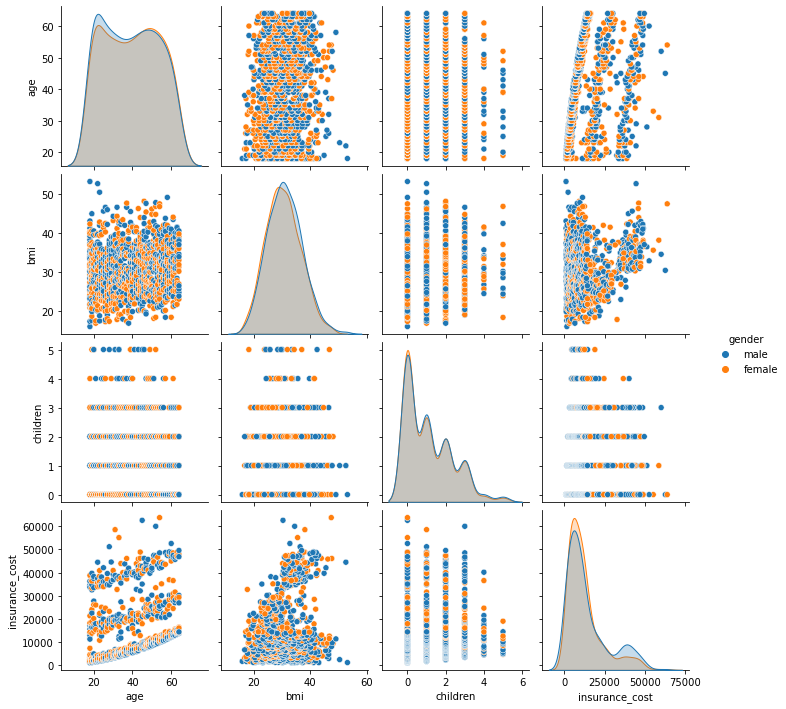

In [9]:
sns.pairplot(hue='gender',data=df)
plt.show()

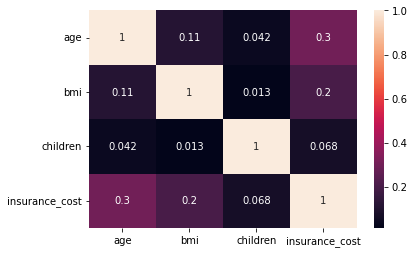

In [10]:
sns.heatmap(df.corr(), annot= True);

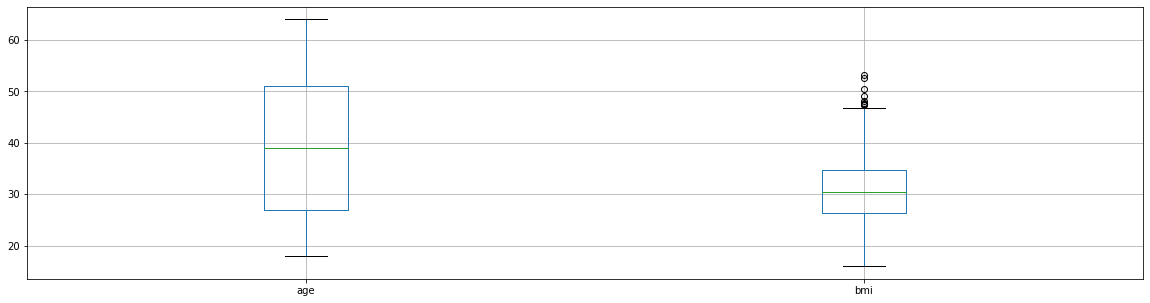

In [11]:
df.loc[:,'age':'bmi'].boxplot(figsize=(20,5))
plt.show()

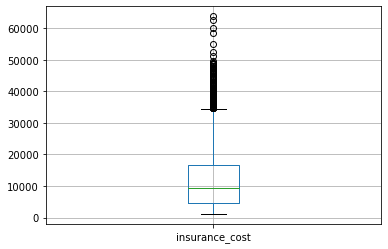

In [12]:
df.boxplot(column=['insurance_cost'])
plt.show()

In [13]:
df['region'].value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

<AxesSubplot:xlabel='age', ylabel='insurance_cost'>

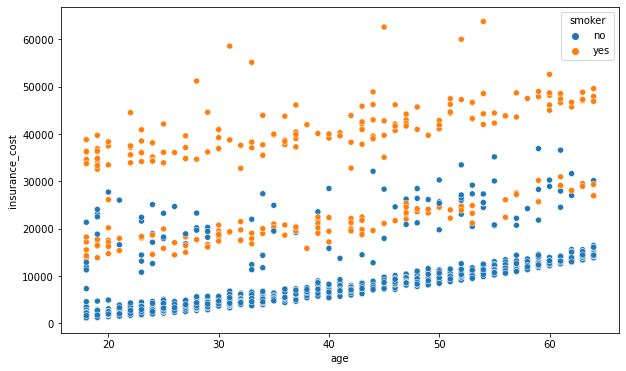

In [14]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='age', y='insurance_cost',hue='smoker')

## Data Preparation

In [15]:
df = pd.get_dummies(df, columns=['gender', 'region','smoker'], 
                        #dummy_na=True, 
                        drop_first=True)

In [16]:
"""scale_mapper = {
    "yes": 0,
    "no": 0, 
}
df['smoker'] = df['smoker'].replace(scale_mapper)"""

'scale_mapper = {\n    "yes": 0,\n    "no": 0, \n}\ndf[\'smoker\'] = df[\'smoker\'].replace(scale_mapper)'

In [17]:
df.head()

age     bmi  children  insurance_cost  gender_male  region_northwest  \
0   18  33.770         1      1725.55230            1                 0   
1   18  34.100         0      1137.01100            1                 0   
2   18  26.315         0      2198.18985            0                 0   
3   18  38.665         2      3393.35635            0                 0   
4   18  35.625         0      2211.13075            0                 0   

   region_southeast  region_southwest  smoker_yes  
0                 1                 0           0  
1                 1                 0           0  
2                 0                 0           0  
3                 0                 0           0  
4                 0                 0           0

In [18]:
df.tail()

age     bmi  children  insurance_cost  gender_male  region_northwest  \
1333   64  31.825         2     16069.08475            0                 0   
1334   64  26.885         0     29330.98315            0                 1   
1335   64  26.410         0     14394.55790            1                 0   
1336   64  36.960         2     49577.66240            1                 0   
1337   64  23.760         0     26926.51440            1                 0   

      region_southeast  region_southwest  smoker_yes  
1333                 0                 0           0  
1334                 0                 0           1  
1335                 0                 0           0  
1336                 1                 0           1  
1337                 1                 0           1

In [19]:
preprocess_pipeline = make_pipeline(StandardScaler())

In [20]:
y = df['insurance_cost']
X = df.drop('insurance_cost', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

## Grid Search for Best Parameters and Best Dimensionality Reduction Method

### Random Forest Pipeline

In [21]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', RandomForestRegressor(n_estimators=10))])

In [22]:
N_FEATURES_OPTIONS = [2, 6, 8]
MAX_DEPTH_OPTIONS = [2, 4, 6, 8]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    }  
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.855:
Best parameters:  {'reduce_dim': RFE(estimator=LinearRegression(), n_features_to_select=8), 'reduce_dim__n_features_to_select': 8, 'regresson__max_depth': 4}


### Linear Regression Pipeline

In [23]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', LinearRegression())])

In [24]:
N_FEATURES_OPTIONS = [2, 6, 8]
#NORMALIZE_OPTIONS = [False, True]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        #'regresson__normalize': NORMALIZE_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        #'regresson__normalize': NORMALIZE_OPTIONS
    }  
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
LR_best_params = search.best_params_
LR_best_model = search.best_estimator_

Best CV score = 0.738:
Best parameters:  {'reduce_dim': RFE(estimator=LinearRegression(), n_features_to_select=6), 'reduce_dim__n_features_to_select': 6}


## Compare Regression Models on Test Set

In [25]:
# model - a trained regression model

def evaluate_model(X_test, y_test, model):
    
    # compute predictiond for the test set
    _predicted_values = model.predict(X_test)
        
    # compute metrics
    _mse = mean_squared_error(y_test, _predicted_values)
    _mae = mean_absolute_error(y_test, _predicted_values)
    _r2 = r2_score(y_test, _predicted_values)
            
    return _mse, _mae, _r2

In [26]:
RF_mse, RF_mae, RF_r2 = evaluate_model(X_test, y_test, RF_best_model)
LR_mse, LR_mae, LR_r2 = evaluate_model(X_test, y_test, LR_best_model)

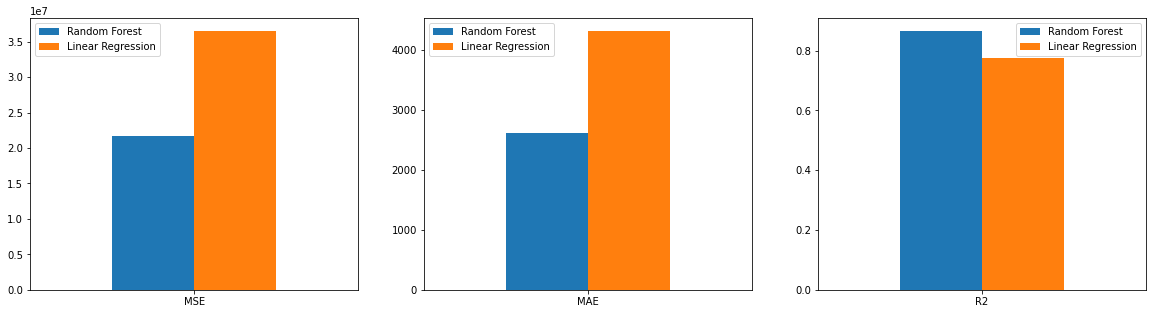

In [27]:
df_mse = pd.DataFrame({'Random Forest': RF_mse, 'Linear Regression': LR_mse}, index=['MSE'])
df_mae = pd.DataFrame({'Random Forest': RF_mae, 'Linear Regression': LR_mae}, index=['MAE'])
df_r2 = pd.DataFrame({'Random Forest': RF_r2, 'Linear Regression': LR_r2}, index=['R2'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

df_mse.plot.bar(rot=0, ax=axes[0])
df_mae.plot.bar(rot=0, ax=axes[1])
df_r2.plot.bar(rot=0, ax=axes[2])

plt.show()

### third regression algorithm - Task 2

In [28]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', KNeighborsRegressor())])

In [29]:
N_FEATURES_OPTIONS = [2, 6, 8]
NEIGHBOURS_OPTIONS = [1, 3, 4, 5, 9]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__n_neighbors': NEIGHBOURS_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__n_neighbors': NEIGHBOURS_OPTIONS
    }
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
KNR_best_params = search.best_params_
KNR_best_model = search.best_estimator_

Best CV score = 0.818:
Best parameters:  {'reduce_dim': RFE(estimator=LinearRegression(), n_features_to_select=6), 'reduce_dim__n_features_to_select': 6, 'regresson__n_neighbors': 9}


### 2 dimensionality-reduction methods - Task 3

In [30]:
N_FEATURES_OPTIONS = [2, 6, 8]
NEIGHBOURS_OPTIONS = [1, 2, 3, 4, 5, 6, 7, 8, 9] 
WEIGHTS = ['uniform', 'distance']

param_grid = [
    {
        'reduce_dim': [FactorAnalysis()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__n_neighbors': NEIGHBOURS_OPTIONS,
        'regresson__weights': WEIGHTS
    },
    {
        'reduce_dim': [KernelPCA(kernel='rbf')],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__n_neighbors': NEIGHBOURS_OPTIONS,
        'regresson__weights': WEIGHTS
    }
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
KNR_t3_best_params = search.best_params_
KNR_t3_best_model = search.best_estimator_

Best CV score = 0.788:
Best parameters:  {'reduce_dim': KernelPCA(kernel='rbf', n_components=8), 'reduce_dim__n_components': 8, 'regresson__n_neighbors': 8, 'regresson__weights': 'distance'}


In [31]:
KNR_mse, KNR_mae, KNR_r2 = evaluate_model(X_test, y_test, KNR_best_model)
KNR_t3_mse, KNR_t3_mae, KNR_t3_r2 = evaluate_model(X_test, y_test, KNR_t3_best_model)

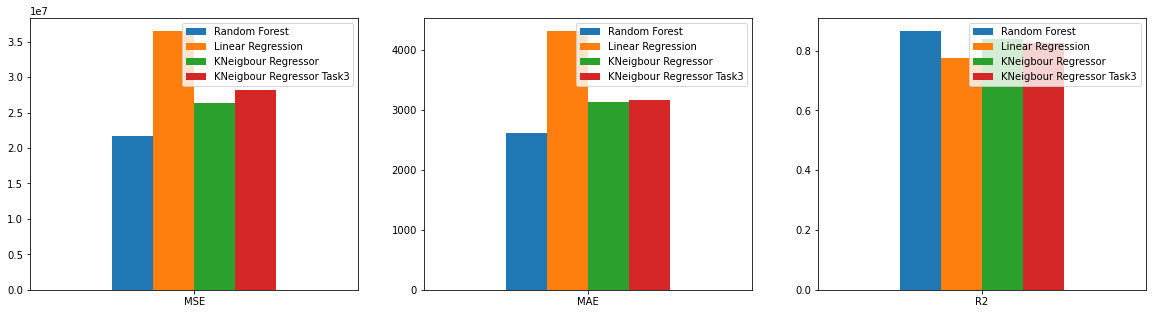

In [32]:
df_mse = pd.DataFrame({'Random Forest': RF_mse, 'Linear Regression': LR_mse, 'KNeigbour Regressor': KNR_mse, 'KNeigbour Regressor Task3': KNR_t3_mse}, index=['MSE'])
df_mae = pd.DataFrame({'Random Forest': RF_mae, 'Linear Regression': LR_mae, 'KNeigbour Regressor': KNR_mae, 'KNeigbour Regressor Task3': KNR_t3_mae}, index=['MAE'])
df_r2 = pd.DataFrame({'Random Forest': RF_r2, 'Linear Regression': LR_r2, 'KNeigbour Regressor': KNR_r2, 'KNeigbour Regressor Task3': KNR_t3_r2}, index=['R2'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

df_mse.plot.bar(rot=0, ax=axes[0])
df_mae.plot.bar(rot=0, ax=axes[1])
df_r2.plot.bar(rot=0, ax=axes[2])

plt.show()

## Train a Final Model

In [33]:
# function to remove the string 'regresson__' from the names of the best parameters
def transform(dict, prefix):
    dict_prefix = {key:value for key,value in dict.items() if prefix in key}
    return {key.replace(prefix,''):value for key,value in dict_prefix.items()}

pipe = make_pipeline(preprocess_pipeline, 
                     RF_best_params.get('reduce_dim'),
                     RandomForestRegressor(n_estimators=10, **transform(RF_best_params, 'regresson__')))

final_model =pipe.fit(X, y)

We can also store this model on disk.

In [34]:
filename = 'final_model.sav'
pickle.dump(final_model, open(filename, 'wb'))